In [1]:
import cv2
import qrcode
import numpy as np
import matplotlib.pyplot as plt
from pyzbar import pyzbar

import config
from utils import *

In [2]:
# path = './images/flipped_scanned_sheet.png'
# img = cv2.imread(path)

# plot_bgr(img);

## The QR Code as the reference point

This was the first idea iteration, it turned out that QR code is omnidirectional, so it can't serve as reference point to deskew the image afterwards

In [3]:
# img.shape

In [4]:
def get_qrcode_coordinates(img):
    resize_dim = config.QRCODE_RESIZE_VALUE
    h_ratio, w_ratio = resize_dim/img.shape[0], resize_dim/img.shape[1]
    img = img.copy()
    img = cv2.resize(img, (resize_dim, resize_dim))
    barcodes = pyzbar.decode(img)
    if not barcodes:
        print("QRCode not found!")
        return
    qr_poly = barcodes[0].polygon
    return np.array([[p.x/w_ratio, p.y/h_ratio] for p in qr_poly], np.int32)

def outline_qrcode(img):
    img = img.copy()
    qr_coords = get_qrcode_coordinates(img)
    if qr_coords is None:
        return
    img2 = cv2.drawContours(img,[qr_coords],0,(0,255,0),5)
    plot_bgr(img2);

In [5]:
# outline_qrcode(img)

In [6]:
# qr_coords = get_qrcode_coordinates(img)
# qr_coords

## Correcting translation + perspective based on the corners

In [7]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

In [8]:
def four_point_transform(img, points):
    # Directly from https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/   
    # unpack rectangle points: top left, top right, bottom right, bottom left
#     hh, ww = img.shape[:2]
    ww, hh = config.TEMPLATE_DIMS[1], config.TEMPLATE_DIMS[0]
#     ww, hh = size, size
    source = np.array(points, dtype="float32")
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [ww, hh],
        [0, hh],
        [0, 0],
        [ww, 0]
    ], dtype = "float32")
    
    print(dst)
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(points, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (ww, hh), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

## Finding image contours

We need to:

1. Find the corners contours to deskew the image
2. Find the answers contours to grade the test

In [9]:
def find_contours(img):
    img = img.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    # To remove excess gray and make edges sharper against background
    # Improves contour detection
    _, gray = cv2.threshold(gray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(gray,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy

### Finding the corners

- We have the base corner to extract features from
- Since the image can be scaled or rotated (and have the perspective slightly inclined), we need to use Hu Moments to identify the corner contours

In [10]:
def calculate_contour_features(contour):
    moments = cv2.moments(contour)
    return cv2.HuMoments(moments)

In [11]:
def calculate_corner_features():
    corner_img = cv2.imread('./images/corner_contour_base.png')
    corner_img_gray = cv2.cvtColor(corner_img, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(
        corner_img_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) != 2:
        raise RuntimeError(
            'Did not find the expected contours when looking for the corner')

    corner_contour = next(ct
                          for i, ct in enumerate(contours)
                          if hierarchy[0][i][3] != -1)

    return calculate_contour_features(corner_contour)

In [12]:
def features_distance(f1, f2):
    "Euclidean distance between the two Hu moment feature vectors"
    return np.linalg.norm(np.array(f1) - np.array(f2))

In [13]:
def find_corner_contours(contours):
    corner_features = calculate_corner_features()
    # Sort contours by similarity with our template corner
    sorted_contours= sorted(
            contours,
            key=lambda c: features_distance(
                    corner_features,
                    calculate_contour_features(c)))

    # We can use a area-based heuristic to find the four corners,
    # Premises:
    # - The first contour is always correct
    # - Other corner elements must be on the 10 most similar contours
    # - The following ones should not have a area and perimeter different by more than
    #   50% of the average area and perimeter of the previous found corners
    #   (area can differ by a good margin depending on perspective distortion)
    corner_contours = [sorted_contours[0]]
    avg_area = cv2.contourArea(sorted_contours[0])
    avg_perimeter = cv2.arcLength(sorted_contours[0], True)
    for i, cnt in enumerate(sorted_contours[1:10]):
        if len(corner_contours) == 4:
            break

        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt,True)
        
        area_diff = abs((area - avg_area) / avg_area)
        perimeter_diff = abs((perimeter - avg_perimeter) / avg_perimeter)
        if not area_diff < .5:
            continue
        if not perimeter_diff < .5:
            continue
        
        corner_contours.append(cnt)
        avg_area = np.mean([cv2.contourArea(x) for x in corner_contours])
        avg_perimeter = np.mean([cv2.arcLength(x, True) for x in corner_contours])
    return corner_contours

In [14]:
def get_centroid(contour):
    m = cv2.moments(contour)
    x = int(m["m10"] / m["m00"])
    y = int(m["m01"] / m["m00"])
    return (x, y)

In [15]:
def sort_rectangle_based_on_qrcode_distance(points, qrcode_coords):
    qrcode_centroid = get_centroid(qrcode_coords)
    distances = [features_distance(point, qrcode_centroid) for point in points]
    sorted_points = [
        x
        for x, _ in 
        sorted(
            zip(points, distances),
            key=lambda x: x[1]
        )
    ]
    tr, tl, br, bl = sorted_points
    return [br, bl, tl, tr]

In [16]:
def sort_corners_based_on_qrcode_distance(corners_contours, qrcode_coords):
    qrcode_centroid = get_centroid(qrcode_coords)
    centroids = [get_centroid(corner) for corner in corners_contours]
    centroid_distance = [features_distance(centroid, qrcode_centroid) for centroid in centroids]
    sorted_corners = [
        x
        for x, _ in 
        sorted(
            zip(corners_contours, centroid_distance),
            key=lambda x: x[1]
        )
    ]
    tr, tl, br, bl = sorted_corners
    return [br, bl, tl, tr]

In [17]:
def get_bounding_rect(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    return np.int0(box)

def get_outmost_points(contours):
    all_points = np.concatenate(contours)
    return get_bounding_rect(all_points)

In [18]:
def sort_points_counter_clockwise(points):
    origin = np.mean(points, axis=0)

    def positive_angle(p):
        x, y = p - origin
        ang = np.arctan2(y, x)
        return 2 * np.pi + ang if ang < 0 else ang

    return sorted(points, key=positive_angle)

In [19]:
def find_sheet_corners(corners):
    edges = []

    contour_edge_orientation = [
        'br', 'bl', 'tl', 'tr'
    ]
    for contour, rect_edge in zip(corners, contour_edge_orientation):
        box = sort_points_counter_clockwise(get_bounding_rect(contour))
        br, bl, tl, tr = box
        rect_edge = eval(rect_edge)
        sorted_contours = np.array([x for x in sorted(contour, key=lambda x: l2_distance(x[0], rect_edge))])
        sorted_points = [x[0] for x in sorted(contour, key=lambda x: l2_distance(x[0], rect_edge))]
        edge = sorted_contours[0][0]
        edges.append(edge)
    return edges

In [20]:
def run(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print("Image is invalid or doesn't exist")

    qr_coords = get_qrcode_coordinates(img)
    contours, _ = find_contours(img)
    corner_contours = find_corner_contours(contours)
    corner_contours = sort_corners_based_on_qrcode_distance(corner_contours, qr_coords)
    outmost = find_sheet_corners(corner_contours)
    centroids = list(map(get_centroid, corner_contours))
        
#     outmost = get_outmost_points(corner_contours)
#     outmost = sort_rectangle_based_on_qrcode_distance(outmost, qr_coords)
    print(outmost)

    transformed = four_point_transform(img, np.array(outmost, dtype='float32'))    
    print(qr_coords)
    
    # Display found QRCode + corner centroids
    img3 = img.copy()
    print(centroids)
    for circle in centroids:
        img3 = cv2.circle(img3, circle, 15, (0,255,0), -1)
    for edge in outmost:
        img3 = cv2.circle(img3, edge, 10, (0,255,255), -1)    
    outline_qrcode(img3) 
    
    # Display found contours
    img2 = img.copy()
    contours, _ = find_contours(img2)
    cv2.drawContours(img2,contours,-1,(0,255,0),5)
    plot_bgr(img2);
    
    # Display deskewed image
    plot_bgr(transformed);
    
    print(pyzbar.decode(transformed))
    return corner_contours, qr_coords

[(470, 726), (77, 729), (74, 88), (468, 86)]
273 408
[496 755] br [array([496, 755]), array([400, 755]), array([400, 659]), array([496, 659])]
[ 49 756] bl [array([145, 756]), array([ 48, 756]), array([ 48, 659]), array([145, 659])]
[48 60] tl [array([145, 156]), array([ 48, 156]), array([48, 60]), array([145,  60])]
[496  59] tr [array([496, 156]), array([399, 156]), array([399,  59]), array([496,  59])]
1 : ['B']
2 : ['B']
3 : ['C']
4 : ['D']
5 : ['E']
6 : ['D']
7 : ['D']
8 : []
9 : []
10 : []
11 : []
12 : []
13 : ['D']
14 : ['E']
15 : ['A']
16 : []
17 : []
18 : []
19 : []
20 : []
21 : []
22 : []
23 : ['B']
24 : ['D']
25 : ['B']
26 : []
27 : ['C']
28 : []
29 : []
30 : []


error: OpenCV(4.5.2) /tmp/pip-req-build-eirhwqtr/opencv/modules/imgproc/src/contours.cpp:195: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


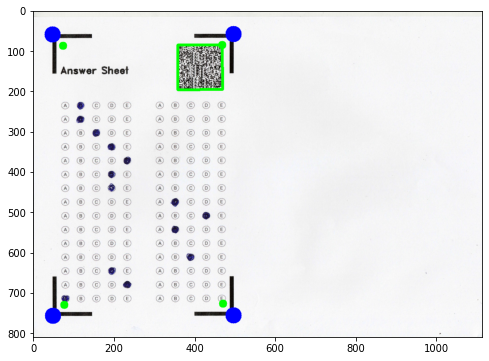

In [21]:
from grade_sheet import run as run_py

# run_py('./images/flipped_scanned_sheet.png')
run_py('./images/scan_marcos.png', 30)
# run_py('./images/cropped_scan_marcos.png', 30)